In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
import global_variables as gv
import output_functions as of
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
run = 132
range_profile = pickle.load(open(
    'Outputs/Logs/run{}/range_profiles'.format(run), 'rb'))
site_profile = pickle.load(
    open('Outputs/Logs/run{}/site_summary'.format(run), 'rb'))
site_profile['date'] = pd.to_datetime(site_profile['date'])
days_summary = pickle.load(
    open('Outputs/Logs/run{}/days_summary'.format(run),'rb'))
status = pickle.load(
    open('Outputs/Logs/run{}/status'.format(run),'rb'))
journeys_range = pickle.load(
    open('Outputs/journeys_range','rb'))

In [7]:
days_summary

,Battery_Use,Session,Return,Output_Opt,Ch_Opt,ChDelivered_Opt,ECost_Opt,Br_Opt,Level_Opt
2019-03-21,-584.783100,292405,20,433.000000,0.0,389.700000,3400.400000,0,Tonext
2019-03-22,-497.616820,309263,20,749.400160,0.0,674.460144,5953.769264,17,Breach
2019-03-23,-468.068300,467493,17,540.342308,0.0,486.308077,4617.629232,0,Main
2019-03-24,-521.439167,307572,20,455.905756,0.0,410.315180,3257.588205,0,Tonext
2019-03-25,-479.941693,300628,20,656.739756,0.0,591.065781,4972.883220,11,Breach
...,...,...,...,...,...,...,...,...,...
2019-10-14,-495.345113,384451,20,391.000000,0.0,351.900000,2499.760000,0,Tonext
2019-10-15,-538.132887,391478,20,753.000000,0.0,677.700000,5159.359997,17,Breach
2019-10-16,-559.315100,371239,20,444.000000,0.0,399.600000,3133.440000,0,Tonext
2019-10-17,-500.714967,406765,20,735.000001,0.0,661.500001,4854.400006,13,Breach


In [8]:
days_summary[days_summary['Level_Opt']=='Magic']

,Battery_Use,Session,Return,Output_Opt,Ch_Opt,ChDelivered_Opt,ECost_Opt,Br_Opt,Level_Opt
2019-04-13,-483.543533,489915,17,676.717386,0.0,609.045647,6075.314094,16,Magic
2019-04-29,-524.249547,323146,20,741.392601,0.0,667.253341,5485.273542,16,Magic
2019-06-30,-541.693727,317336,20,601.881919,0.0,541.693727,2905.452828,14,Magic
2019-07-12,-560.474433,353876,20,622.749259,0.0,560.474333,4861.775514,17,Magic
2019-08-01,-573.866780,352659,20,646.409807,0.0,581.768826,4722.808048,16,Magic
2019-08-27,-520.834793,389734,21,578.705215,0.0,520.834693,3900.647878,17,Magic
2019-09-14,-541.655633,407774,20,743.980970,0.0,669.582873,3819.741057,17,Magic


In [14]:
day = dt.datetime(2019, 4, 13)
site_profile[site_profile['date']==day].sort_values(by='Output_Opt')


,Electricity_Price,Available,Battery_Use,Session,Return,Output_Opt,Ch_Opt,ChDelivered_Opt,ECost_Opt,SoC_Opt,N_Opt,Br_Opt,date,day,time
from,,,,,,,,,,,,,,,
2019-04-13 08:00:00,11.60,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,83.266385,0,False,2019-04-13,2019-04-13,08:00:00
2019-04-14 06:30:00,9.00,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,100.000000,0,False,2019-04-13,2019-04-14,06:30:00
2019-04-14 07:00:00,9.00,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,100.000000,0,False,2019-04-13,2019-04-14,07:00:00
2019-04-13 12:30:00,7.60,0,-53.944073,0,2,0.000000,0.0,0.000000,0.000000,72.525239,0,False,2019-04-13,2019-04-13,12:30:00
2019-04-13 12:00:00,7.74,0,-26.614520,0,1,0.000000,0.0,0.000000,0.000000,79.717782,0,False,2019-04-13,2019-04-13,12:00:00
2019-04-13 11:30:00,7.90,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,83.266385,0,False,2019-04-13,2019-04-13,11:30:00
2019-04-14 07:30:00,8.34,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,100.000000,0,False,2019-04-13,2019-04-14,07:30:00
2019-04-13 10:30:00,8.60,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,83.266385,0,False,2019-04-13,2019-04-13,10:30:00
2019-04-13 10:00:00,9.32,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,83.266385,0,False,2019-04-13,2019-04-13,10:00:00


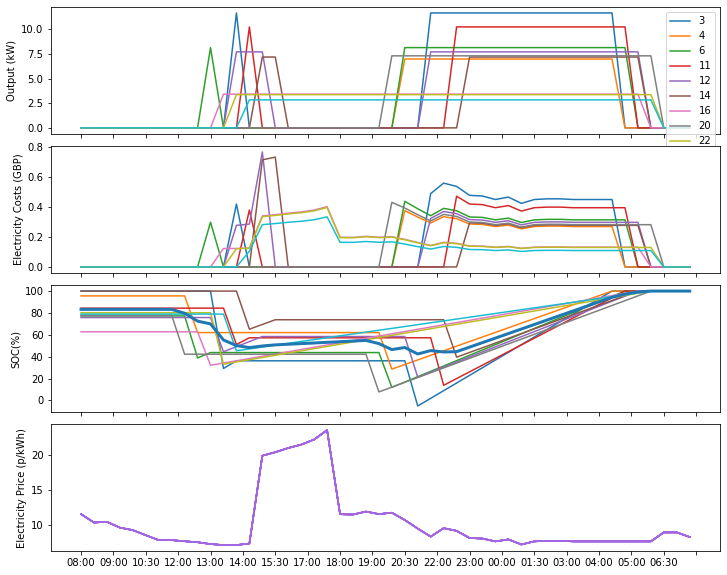

In [11]:
profile = range_profile[range_profile['date']==day]

fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='opt'
x = profile.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    profile.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(profile.unstack()[cols['OUTPUT'][ca]].columns)
# axs[0].plot(
#     x,
#     range_profile[cols['OUTPUT'][ca]].groupby('from').sum()*2, linewidth=3)
axs[0].set_ylabel('Output (kW)')

axs[1].plot(
    x, 
    profile.unstack()[cols['ECOST'][ca]]/100)
# axs[1].plot(
#     x,
#     range_profile[cols['ECOST'][ca]].groupby('from').sum()/100, linewidth=3)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    profile.unstack()[cols['SOC'][ca]])
axs[2].plot(
    x,
    profile[cols['SOC'][ca]].groupby('from').mean(), linewidth=3)
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    profile.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))
fig.show()

In [75]:
# Calculates how much charging occurs between arrival and 10pm
days_summary['Charge_late'] = 0
vehicles = profile.index.get_level_values('Vehicle_ID').unique()
for date in days_summary.index:
    profile = range_profile[range_profile['date']==date]
    cutoff = dt.datetime.combine(
        date.to_pydatetime(), dt.time(22,0,0))
    charge = 0
    for veh in vehicles:  
        temp = profile.loc[
            (slice(cutoff), veh), ['Session', 'Output_Opt']]
        last_session = temp['Session'].max()
        charge += temp[temp['Session']==last_session]['Output_Opt'].sum()
    days_summary.loc[date,'Charge_late'] = charge
days_summary['Ratio'] = days_summary['Charge_late'] / days_summary['Output_Opt']
days_summary['Ratio'].describe()

count    210.000000
mean       0.213526
std        0.055087
min        0.000000
25%        0.181145
50%        0.214675
75%        0.247454
max        0.373895
Name: Ratio, dtype: float64